In [1]:
import config
import requests
import pandas as pd
from pandas import json_normalize
import json
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', palette='dark')


## Authenticate with Strava

In [2]:
with open('strava_tokens.json') as json_file:
    strava_tokens = json.load(json_file)

if strava_tokens['expires_at'] < time.time():
    response = requests.post(
                        url = 'https://www.strava.com/oauth/token',
                        data = {
                                'client_id': config.client_id,
                                'client_secret': config.client_secret,
                                'grant_type': 'refresh_token',
                                'refresh_token': strava_tokens['refresh_token']
                                }
                    )
    new_strava_tokens = response.json()

    with open('strava_tokens.json', 'w') as outfile:
        json.dump(new_strava_tokens, outfile)

    strava_tokens = new_strava_tokens

In [3]:
with open('strava_tokens.json') as check:
  data = json.load(check)

In [4]:
# Get the tokens from file to connect to Strava
with open('strava_tokens.json') as json_file:
    strava_tokens = json.load(json_file)
# Loop through all activities
url = "https://www.strava.com/api/v3/activities"
access_token = strava_tokens['access_token']
# Get first page of activities from Strava with all fields
r = requests.get(url + '?access_token=' + access_token)
r = r.json()
    
df = json_normalize(r)
df.to_csv('strava_activities_all_fields.csv')

## Data Retrieval

In [5]:
header = {'Authorization': 'Bearer ' + access_token}
param = {'per_page': 200, 'page': 1}
r = requests.get(url, headers=header, params=param).json()

In [6]:
activities = json_normalize(r)

# new dataframe with desired columns
columns = [
            "id",
            "name",
            "start_date_local",
            "type",
            "distance",
            "moving_time",
            "elapsed_time",
            "total_elevation_gain",
            "end_latlng",
            "location_country",
            "flagged",
            "has_heartrate",
            "average_heartrate",
            "max_heartrate",
            "average_speed"
    ]

activities = activities[columns]

# Export activities file as a csv 
# to the folder this script runs in
activities.to_csv('strava_activities.csv')

## Data Exploration

In [7]:
activities.head()

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,end_latlng,location_country,flagged,has_heartrate,average_heartrate,max_heartrate,average_speed
0,6362464831,"Went out for a run, simple!",2021-12-09T12:33:58Z,Run,4835.8,1492,1492,49.0,"[41.9611475430429, 3.040450466796756]",Spain,False,True,143.4,158.0,3.241
1,6345939956,Mitja Marató de Figueres 2021,2021-12-05T10:30:05Z,Run,21219.2,5976,5992,60.4,"[42.26630539633334, 2.9646223224699497]",Spain,False,True,160.5,192.0,3.541
2,6333698342,Taper Run,2021-12-02T12:44:09Z,Run,6446.0,1853,1856,10.6,"[41.96143009699881, 3.0379427690058947]",Spain,False,True,148.3,165.0,3.479
3,6325439450,Taper run,2021-11-30T13:05:44Z,Run,6438.6,1850,1850,10.2,"[41.96177165955305, 3.037542700767517]",Spain,False,True,155.0,168.0,3.480
4,6316772468,Still recovering,2021-11-28T11:02:59Z,Run,9655.9,3003,3123,55.4,"[41.960421334952116, 3.0389138124883175]",Spain,False,True,151.2,168.0,3.215


### Data Conversion

In [8]:
# Create a distance in miles column
conv_fac_kilometers_miles = 0.621371 # conversion factor
activities['distance_miles'] = (activities['distance']*conv_fac_kilometers_miles)/1e3

# Convert m/s to min/mile
activities['minute_mile'] = 1/(activities['average_speed']/26.822)

# Convert dates to datetime type
activities['start_date_local'] = pd.to_datetime(activities['start_date_local'])

# Create a day of the week and month of the year columns
activities['day_of_week'] = activities['start_date_local'].dt.day_name()
activities['month_of_year'] = activities['start_date_local'].dt.month

# Convert times to timedeltas
activities['moving_time'] = pd.to_timedelta(activities['moving_time'])
activities['elapsed_time'] = pd.to_timedelta(activities['elapsed_time'])

# Convert start date to years
activities['year'] = pd.DatetimeIndex(activities['start_date_local']).year

activities.head()

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,end_latlng,location_country,flagged,has_heartrate,average_heartrate,max_heartrate,average_speed,distance_miles,minute_mile,day_of_week,month_of_year,year
0,6362464831,"Went out for a run, simple!",2021-12-09 12:33:58+00:00,Run,4835.8,0 days 00:00:00.000001492,0 days 00:00:00.000001492,49.0,"[41.9611475430429, 3.040450466796756]",Spain,False,True,143.4,158.0,3.241,3.004826,8.275841,Thursday,12,2021
1,6345939956,Mitja Marató de Figueres 2021,2021-12-05 10:30:05+00:00,Run,21219.2,0 days 00:00:00.000005976,0 days 00:00:00.000005992,60.4,"[42.26630539633334, 2.9646223224699497]",Spain,False,True,160.5,192.0,3.541,13.184996,7.574696,Sunday,12,2021
2,6333698342,Taper Run,2021-12-02 12:44:09+00:00,Run,6446.0,0 days 00:00:00.000001853,0 days 00:00:00.000001856,10.6,"[41.96143009699881, 3.0379427690058947]",Spain,False,True,148.3,165.0,3.479,4.005357,7.709687,Thursday,12,2021
3,6325439450,Taper run,2021-11-30 13:05:44+00:00,Run,6438.6,0 days 00:00:00.000001850,0 days 00:00:00.000001850,10.2,"[41.96177165955305, 3.037542700767517]",Spain,False,True,155.0,168.0,3.480,4.000759,7.707471,Tuesday,11,2021
4,6316772468,Still recovering,2021-11-28 11:02:59+00:00,Run,9655.9,0 days 00:00:00.000003003,0 days 00:00:00.000003123,55.4,"[41.960421334952116, 3.0389138124883175]",Spain,False,True,151.2,168.0,3.215,5.999896,8.342768,Sunday,11,2021


### Get Only Half Marathon Training Activities

Excluding the Half Marathon Race data.

In [9]:
start_date = '2021-10-23T12:44:09Z'
end_date = '2021-12-04T12:44:09Z'

mask = (activities['start_date_local'] > start_date) & (activities['start_date_local'] <= end_date)

df = activities.loc[mask]

df.head()

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,end_latlng,location_country,flagged,has_heartrate,average_heartrate,max_heartrate,average_speed,distance_miles,minute_mile,day_of_week,month_of_year,year
2,6333698342,Taper Run,2021-12-02 12:44:09+00:00,Run,6446.0,0 days 00:00:00.000001853,0 days 00:00:00.000001856,10.6,"[41.96143009699881, 3.0379427690058947]",Spain,False,True,148.3,165.0,3.479,4.005357,7.709687,Thursday,12,2021
3,6325439450,Taper run,2021-11-30 13:05:44+00:00,Run,6438.6,0 days 00:00:00.000001850,0 days 00:00:00.000001850,10.2,"[41.96177165955305, 3.037542700767517]",Spain,False,True,155.0,168.0,3.480,4.000759,7.707471,Tuesday,11,2021
4,6316772468,Still recovering,2021-11-28 11:02:59+00:00,Run,9655.9,0 days 00:00:00.000003003,0 days 00:00:00.000003123,55.4,"[41.960421334952116, 3.0389138124883175]",Spain,False,True,151.2,168.0,3.215,5.999896,8.342768,Sunday,11,2021
5,6308769031,Breaking the Ice after Gastroenteritis,2021-11-26 10:52:14+00:00,Run,7563.2,0 days 00:00:00.000002487,0 days 00:00:00.000002493,60.0,"[41.96040934883058, 3.039237018674612]",Spain,False,True,135.9,156.0,3.041,4.699553,8.820125,Friday,11,2021
6,6286437698,Brief,2021-11-21 08:51:45+00:00,Run,4830.3,0 days 00:00:00.000001380,0 days 00:00:00.000001380,11.9,"[41.96025302633643, 3.0402249097824097]",Spain,False,True,149.0,160.0,3.500,3.001408,7.663429,Sunday,11,2021


## Graphing

The target race pace was 7:30 min / mile. Most of the training that occured in the 6 week period before race day was done above race pace. Two exceptions, where the average pace for the run was below race pace.

Running distance per session ranged from 3 to 10 miles.The Half Marathon race distance (13.1 miles) was never run in training in the 6 weeks prior to race day.

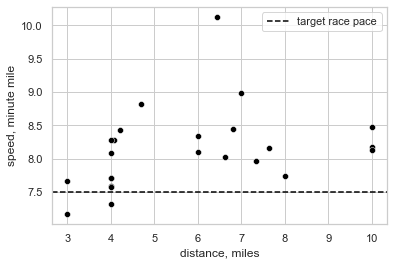

In [10]:
ax = sns.scatterplot(x='distance_miles', y='minute_mile', data=df, color = 'black')
ax.set(xlabel="distance, miles", ylabel = "speed, minute mile")
plt.axhline(y=7.5, color = "black", linestyle='--', label="target race pace")

plt.legend()
plt.show()

The first half of the week (Monday to Wednesday) where lighter distance days, when compared to the later half (Thursday to Sunday).

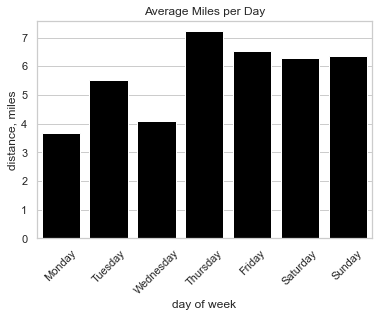

In [11]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]

ax = sns.barplot(x='day_of_week', y='distance_miles', data=df, order=days_of_week, ci=None, color='black')
ax.set(xlabel="day of week", ylabel = "distance, miles", title = "Average Miles per Day")
plt.xticks(rotation=45)
plt.show()